<a href="https://colab.research.google.com/github/Muhammadsulton1/ML/blob/main/simpsons_baseline_my_work_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install scheduler

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [2]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [4]:
!unzip -q /content/gdrive/MyDrive/journey-springfield.zip

In [5]:
!nvidia-smi
import torch
torch.cuda.is_available()

Sun Jun 18 07:38:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8    10W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

В нашем тесте будет 990 картнок, для которых вам будет необходимо предсказать класс.

In [101]:
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms
from multiprocessing.pool import ThreadPool
from sklearn.preprocessing import LabelEncoder
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import PIL
import scheduler
from matplotlib import colors, pyplot as plt
%matplotlib inline

# в sklearn не все гладко, чтобы в colab удобно выводить картинки
# мы будем игнорировать warnings
import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [7]:
# разные режимы датасета
DATA_MODES = ['train', 'val', 'test']
# все изображения будут масштабированы к размеру 224x224 px
RESCALE_SIZE = 224
# работаем на видеокарте
DEVICE = torch.device("cuda")

https://jhui.github.io/2018/02/09/PyTorch-Data-loading-preprocess_torchvision/


Ниже мы исспользуем враппер над датасетом для удобной работы. Вам стоит понимать, что происходит с LabelEncoder и  с torch.Transformation.

ToTensor конвертирует  PIL Image с параметрами в диапазоне [0, 255] (как все пиксели) в FloatTensor размера (C x H x W) [0,1] , затем производится масштабирование:
$input = \frac{input - \mu}{\text{standard deviation}} $, <br>       константы - средние и дисперсии по каналам на основе ImageNet


Стоит также отметить, что мы переопределяем метод __getitem__ для удобства работы с данной структурой данных.
 Также используется LabelEncoder для преобразования строковых меток классов в id и обратно. В описании датасета указано, что картинки разного размера, так как брались напрямую с видео, поэтому следуем привести их к одному размер (это делает метод  _prepare_sample)

In [121]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)

        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)

    def __len__(self):
        return self.len_

    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image

    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform = A.Compose([
        A.HorizontalFlip(p=0.3),
        A.MedianBlur(blur_limit=7,p=0.5),
        A.RandomBrightnessContrast(p=0.2),
        A.CLAHE(clip_limit=4.0, tile_grid_size=(4, 4)),
        A.MotionBlur(p=0.5),
        A.GaussNoise(p=0.5),
        A.RandomShadow(p=0.5),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        A.RandomBrightnessContrast(p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),])

        x = self.load_sample(self.files[index])
        x = self._prepare_sample(x)
        #x = np.array(x / 255, dtype='float32')
        x = transform(image=x)["image"]
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [122]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    """Imshow для тензоров"""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

In [123]:
TRAIN_DIR = Path('/content/train')
TEST_DIR = Path('/content/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))

In [124]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, \
                                          stratify=train_val_labels)

In [125]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

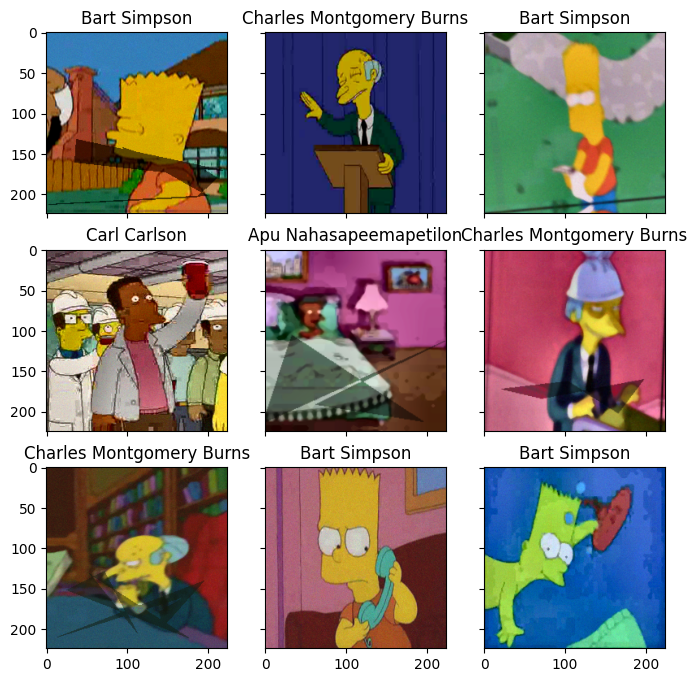

In [126]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

In [23]:
from torchvision.models import resnet50,wide_resnet50_2

In [24]:
def set_parameter_requires_grad(model):
  for param in model.parameters():
    param.requires_grad = True

In [127]:
class ResNet(nn.Module):
  def __init__(self, n_classes):
    super().__init__()

    self.model = wide_resnet50_2(pretrained=True)
    set_parameter_requires_grad(self.model)
    num_features = self.model.fc.in_features

    self.model.fc = nn.Linear(num_features, n_classes)

  def forward(self, input):

    logits = self.model(input)
    return logits

In [128]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)

    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

In [129]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

In [130]:
def train(train_files, val_files, model, epochs, batch_size, l_r):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters(), lr = l_r)
        criterion = nn.CrossEntropyLoss()
        # для уменьшения lr каждую эпоху в два раза
        scheduler = torch.optim.lr_scheduler.StepLR(opt, 1, gamma=0.5)


        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)

            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))

            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step()
            # для сохранения чекпоинтов на всякий случай
            torch.save(model.state_dict(), "/content/state_dict_resnet50" + str(epoch) + ".pth")


    return history

In [131]:
def predict(model, test_loader):
    with torch.no_grad():
        logits = []

        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)

    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [132]:
n_classes = len(np.unique(train_val_labels))
resnet = ResNet(n_classes).to(DEVICE)
print("we will classify :{}".format(n_classes))
print(resnet)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Wide_ResNet50_2_Weights.IMAGENET1K_V1`. You can also use `weights=Wide_ResNet50_2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


we will classify :42
ResNet(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample)

Запустим обучение сети.

In [133]:
if val_dataset is None:
    val_dataset = SimpsonsDataset(val_files, mode='val')

train_dataset = SimpsonsDataset(train_files, mode='train')

In [134]:
history = train(train_dataset, val_dataset, model=resnet, epochs=20, batch_size=64, l_r = 0.0001)

epoch:   0%|          | 0/20 [00:00<?, ?it/s]

loss 0.8144140774524739


epoch:   5%|▌         | 1/20 [10:45<3:24:26, 645.59s/it]


Epoch 001 train_loss: 0.8144     val_loss 0.3283 train_acc 0.8197 val_acc 0.9226
loss 0.25031645801239877


epoch:  10%|█         | 2/20 [21:04<3:08:58, 629.93s/it]


Epoch 002 train_loss: 0.2503     val_loss 0.2644 train_acc 0.9362 val_acc 0.9327
loss 0.10630899845449908


epoch:  15%|█▌        | 3/20 [31:11<2:55:33, 619.62s/it]


Epoch 003 train_loss: 0.1063     val_loss 0.1354 train_acc 0.9723 val_acc 0.9679
loss 0.059215373385934335


epoch:  20%|██        | 4/20 [41:05<2:42:28, 609.30s/it]


Epoch 004 train_loss: 0.0592     val_loss 0.1179 train_acc 0.9853 val_acc 0.9748
loss 0.04010954980139559


epoch:  25%|██▌       | 5/20 [51:06<2:31:33, 606.21s/it]


Epoch 005 train_loss: 0.0401     val_loss 0.1055 train_acc 0.9898 val_acc 0.9771
loss 0.031613054708193575


epoch:  30%|███       | 6/20 [1:01:06<2:20:58, 604.19s/it]


Epoch 006 train_loss: 0.0316     val_loss 0.1037 train_acc 0.9928 val_acc 0.9780
loss 0.027555847704887428


epoch:  35%|███▌      | 7/20 [1:11:10<2:10:55, 604.29s/it]


Epoch 007 train_loss: 0.0276     val_loss 0.0996 train_acc 0.9933 val_acc 0.9790
loss 0.02682014932108841


epoch:  40%|████      | 8/20 [1:21:17<2:00:59, 604.99s/it]


Epoch 008 train_loss: 0.0268     val_loss 0.0996 train_acc 0.9936 val_acc 0.9788
loss 0.02361266179860321


epoch:  45%|████▌     | 9/20 [1:31:24<1:51:03, 605.76s/it]


Epoch 009 train_loss: 0.0236     val_loss 0.1044 train_acc 0.9943 val_acc 0.9769
loss 0.02267612821246148


epoch:  50%|█████     | 10/20 [1:41:36<1:41:16, 607.64s/it]


Epoch 010 train_loss: 0.0227     val_loss 0.0993 train_acc 0.9949 val_acc 0.9809
loss 0.023175059610736203


epoch:  55%|█████▌    | 11/20 [1:51:54<1:31:37, 610.84s/it]


Epoch 011 train_loss: 0.0232     val_loss 0.0950 train_acc 0.9945 val_acc 0.9799
loss 0.02369681083863732


epoch:  60%|██████    | 12/20 [2:01:47<1:20:43, 605.47s/it]


Epoch 012 train_loss: 0.0237     val_loss 0.1050 train_acc 0.9939 val_acc 0.9788
loss 0.023930830295244888


epoch:  65%|██████▌   | 13/20 [2:11:39<1:10:08, 601.28s/it]


Epoch 013 train_loss: 0.0239     val_loss 0.1024 train_acc 0.9946 val_acc 0.9782
loss 0.02224193343038388


epoch:  70%|███████   | 14/20 [2:21:29<59:46, 597.71s/it]


Epoch 014 train_loss: 0.0222     val_loss 0.0988 train_acc 0.9950 val_acc 0.9794
loss 0.02254919410225295


epoch:  75%|███████▌  | 15/20 [2:31:22<49:42, 596.44s/it]


Epoch 015 train_loss: 0.0225     val_loss 0.1000 train_acc 0.9942 val_acc 0.9803
loss 0.02305797070718761


epoch:  80%|████████  | 16/20 [2:41:37<40:08, 602.04s/it]


Epoch 016 train_loss: 0.0231     val_loss 0.1044 train_acc 0.9943 val_acc 0.9778
loss 0.022509666540755417


epoch:  85%|████████▌ | 17/20 [2:51:25<29:53, 597.74s/it]


Epoch 017 train_loss: 0.0225     val_loss 0.1036 train_acc 0.9946 val_acc 0.9788
loss 0.023033226287716535


epoch:  90%|█████████ | 18/20 [3:01:13<19:49, 594.98s/it]


Epoch 018 train_loss: 0.0230     val_loss 0.1014 train_acc 0.9946 val_acc 0.9794
loss 0.02214678800685902


epoch:  95%|█████████▌| 19/20 [3:11:09<09:55, 595.24s/it]


Epoch 019 train_loss: 0.0221     val_loss 0.1064 train_acc 0.9946 val_acc 0.9788
loss 0.02093029620574792


epoch: 100%|██████████| 20/20 [3:21:12<00:00, 597.54s/it]


Epoch 020 train_loss: 0.0209     val_loss 0.0987 train_acc 0.9950 val_acc 0.9790


epoch: 100%|██████████| 20/20 [3:21:13<00:00, 603.67s/it]


Построим кривые обучения

In [135]:
loss, acc, val_loss, val_acc = zip(*history)

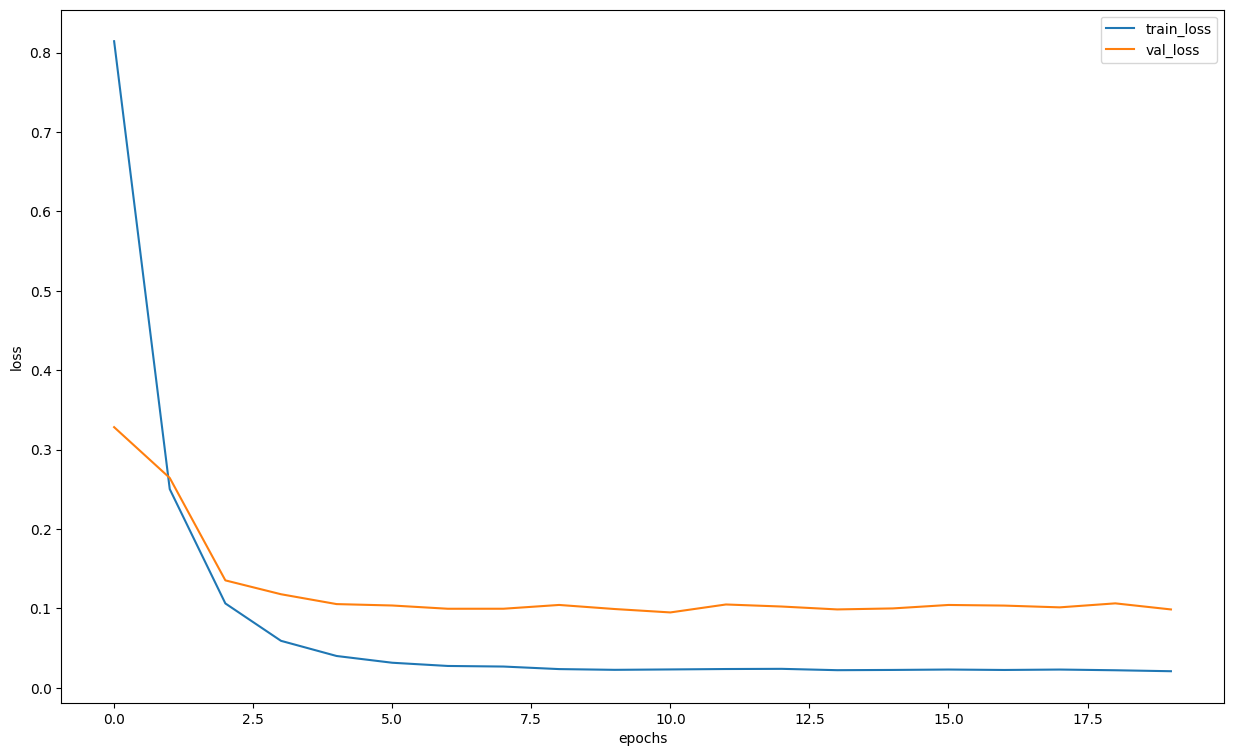

In [136]:
plt.figure(figsize=(15, 9))
plt.plot(loss, label="train_loss")
plt.plot(val_loss, label="val_loss")
plt.legend(loc='best')
plt.xlabel("epochs")
plt.ylabel("loss")
plt.show()

In [137]:
def predict_one_sample(model, inputs, device=DEVICE):
    """Предсказание, для одной картинки"""
    with torch.no_grad():
        inputs = inputs.to(device)
        model.eval()
        logit = model(inputs).cpu()
        probs = torch.nn.functional.softmax(logit, dim=-1).numpy()
    return probs

In [138]:
random_characters = int(np.random.uniform(0,1000))
ex_img, true_label = val_dataset[random_characters]
probs_im = predict_one_sample(resnet, ex_img.unsqueeze(0))

In [139]:
idxs = list(map(int, np.random.uniform(0,1000, 20)))
imgs = [val_dataset[id][0].unsqueeze(0) for id in idxs]

probs_ims = predict(resnet, imgs)

In [140]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

In [142]:
y_pred = np.argmax(probs_ims,-1)

actual_labels = [val_dataset[id][1] for id in idxs]

# print(f1_score(actual_labels, y_pred))

preds_class = [label_encoder.classes_[i] for i in y_pred]

In [143]:
len(actual_labels)

20

In [144]:
len(preds_class)

20

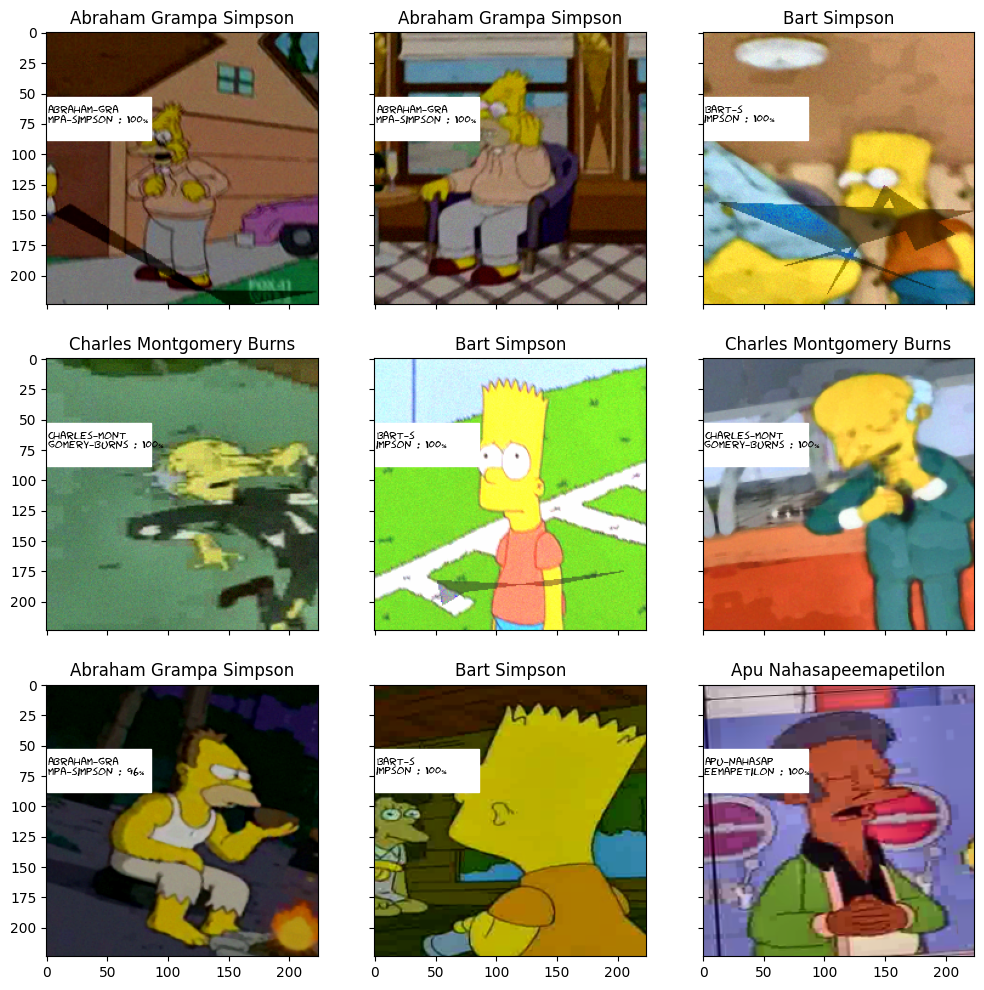

In [146]:
import matplotlib.patches as patches
from matplotlib.font_manager import FontProperties

fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(12, 12), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))



    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)

    actual_text = "Actual : {}".format(img_label)

    fig_x.add_patch(patches.Rectangle((0, 53),86,35,color='white'))
    font0 = FontProperties()
    font = font0.copy()
    font.set_family("fantasy")
    prob_pred = predict_one_sample(resnet, im_val.unsqueeze(0))
    predicted_proba = np.max(prob_pred)*100
    y_pred = np.argmax(prob_pred)

    predicted_label = label_encoder.classes_[y_pred]
    predicted_label = predicted_label[:len(predicted_label)//2] + '\n' + predicted_label[len(predicted_label)//2:]
    predicted_text = "{} : {:.0f}%".format(predicted_label,predicted_proba)

    fig_x.text(1, 59, predicted_text , horizontalalignment='left', fontproperties=font,
                    verticalalignment='top',fontsize=8, color='black',fontweight='bold')

### Submit на Kaggle

In [147]:
test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=64)
probs = predict(resnet, test_loader)


preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
test_filenames = [path.name for path in test_dataset.files]

In [ ]:
! ls

In [148]:
import pandas as pd
my_submit = pd.read_csv("/content/sample_submission.csv")
# my_submit = pd.DataFrame({'Image_id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,bart_simpson
1,img1.jpg,bart_simpson
2,img2.jpg,bart_simpson
3,img3.jpg,bart_simpson
4,img4.jpg,bart_simpson


In [ ]:
# TODO : сделайте сабмит (это важно, если Вы не справляетесь, но дошли до этой ячейки, то сообщите в чат и Вам помогут)

In [149]:
my_submit = pd.DataFrame({'Id': test_filenames, 'Expected': preds})
my_submit.head()

,Id,Expected
0,img0.jpg,nelson_muntz
1,img1.jpg,bart_simpson
2,img10.jpg,ned_flanders
3,img100.jpg,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon


In [150]:
my_submit.to_csv('simpsons_sub.csv', index=False)